# Chainerのチュートリアルを一通り試す

### データセットの準備

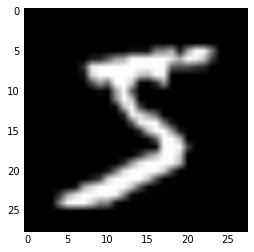

label: 5


In [1]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

# データの例示
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

### Iteratorの作成

In [2]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### モデルの定義

In [3]:
import numpy
numpy.random.seed(0)
import chainer
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)
    
import chainer
import chainer.links as L
import chainer.functions as F


class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(n_mid_units, n_mid_units)
            self.l3=L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0

model = MLP()
#model.to_gpu(gpu_id)  # CPUで処理を行いたい場合は、この行をコメントアウトしてください。

### 最適化手法の選択

In [ ]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

### 学習ループ

In [ ]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch)

    # 予測値の計算
    y = model(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch)

            # テストデータをforward
            y_test = model(x_test)

            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(to_cpu(loss_test.data))

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

### 学習済みモデルを保存する

In [ ]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

### 保存したモデルを読み込んで推論する

In [ ]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_model)

# GPU上で計算させるために、モデルをGPUに送る
#infer_model.to_gpu(gpu_id)

# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [ ]:
from chainer.cuda import to_gpu

# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# GPU上で計算させるため、データもGPU上に送る
#x = to_gpu(x, 0)  # CPU上で行う場合は、ここをコメントアウトしてください。

# モデルのforward関数に渡す
y = infer_model(x)

# Variable形式で出てくるので中身を取り出す
y = y.data

# 結果をCPUに送る
#y = to_cpu(y)  # CPU上で行う場合は、ここをコメントアウトしてください。

# 最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

## trainerを使ってみる

### updaterの準備

In [5]:
from chainer import optimizers
from chainer import training

max_epoch = 10
gpu_id = 0

# モデルをClassifierで包んで、ロスの計算などをモデルに含める
model = L.Classifier(model)
#model.to_gpu(gpu_id)  # CPUを使用する場合は、この行をコメントアウトして下さい。

# 最適化手法の選択
optimizer = optimizers.SGD()
optimizer.setup(model)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer,)

### trainerの設定とextensionの追加

In [6]:
# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### 学習を開始する

In [7]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.50938     0.645689       0.746824              0.83307                   1.8041        
2           0.577556    0.857493       0.450952              0.883505                  4.27657       
3           0.425336    0.884362       0.371797              0.89913                   6.66905       
4           0.368919    0.896585       0.337575              0.903975                  9.01938       
5           0.337852    0.904534       0.310337              0.912085                  11.483        
6           0.316037    0.909931       0.29458               0.91515                   14.0178       
7           0.299505    0.915229       0.280123              0.918908                  16.5572       
8           0.285637    0.918837       0.26914               0.922172                  18.9495       
9           0.273876    0.921675       0.259746              0.924446               

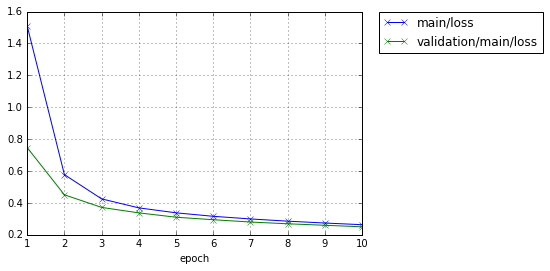

In [11]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

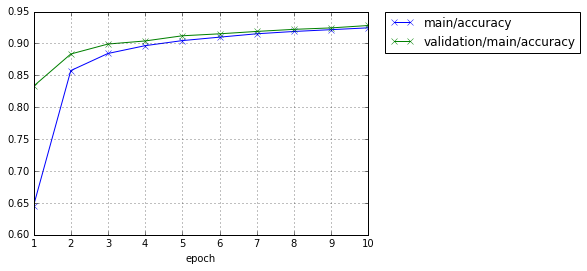

In [10]:
Image(filename='mnist_result/accuracy.png')

In [18]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

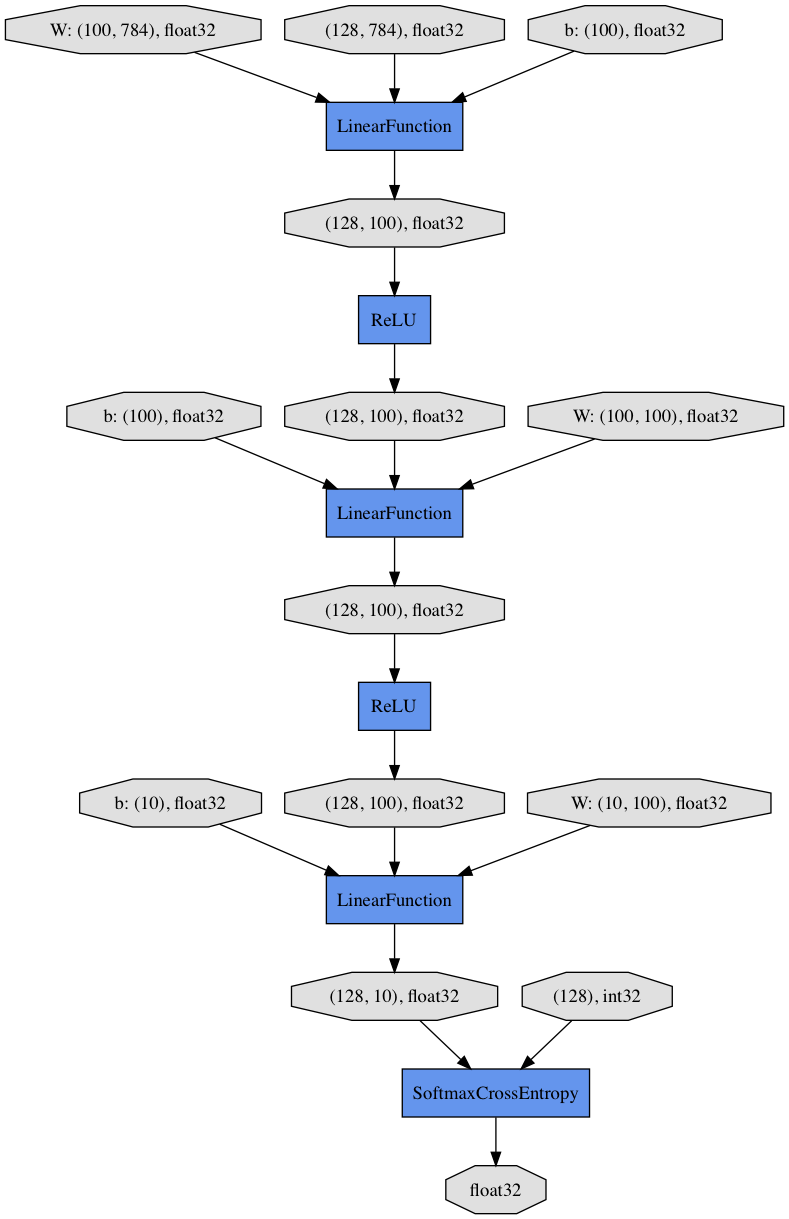

In [19]:
Image(filename='mnist_result/cg.png')

### 推論

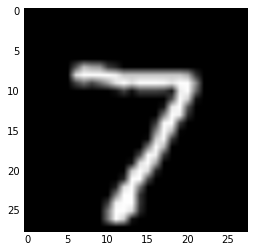

label: 7
predicted_label: 7


In [21]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)
#model.to_gpu(gpu_id)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

x = to_cpu(x[None, ...])
y = model(x)
y = to_cpu(y.data)

print('predicted_label:', y.argmax(axis=1)[0])